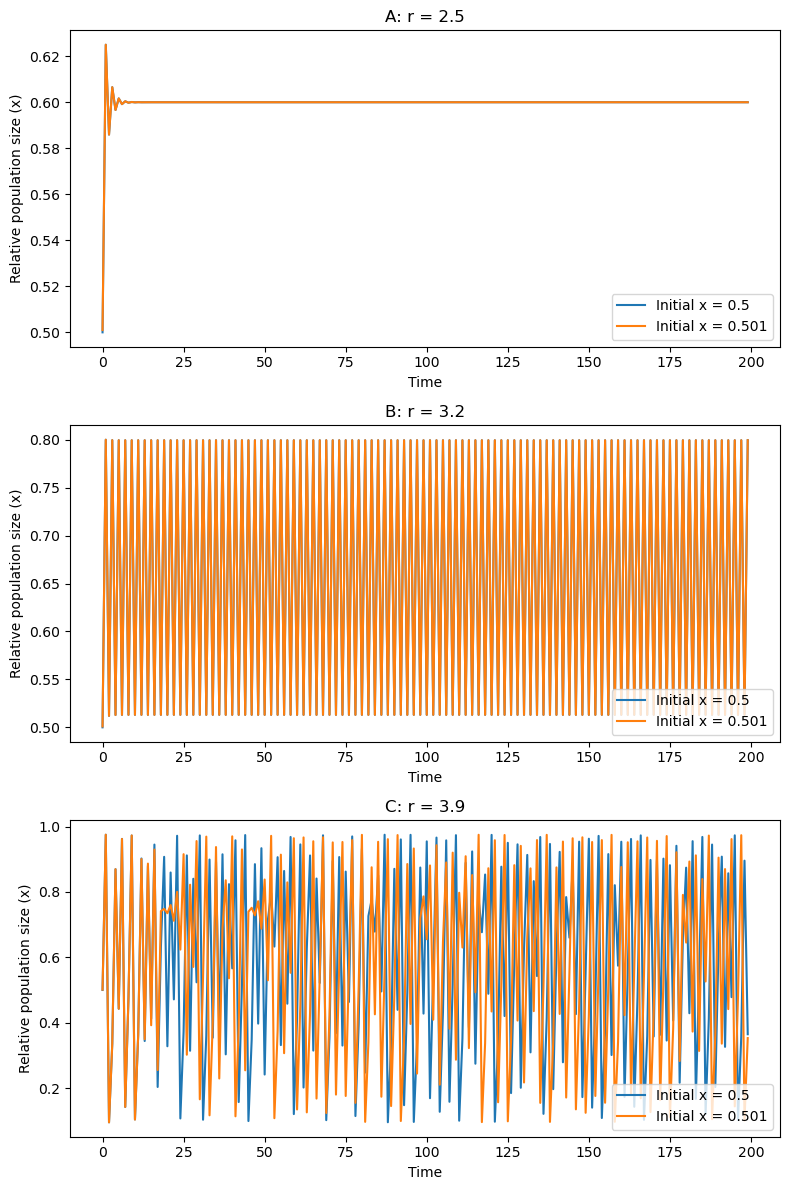

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
from sklearn.metrics import mutual_info_score

# logistic map function
def logistic_map(x, r):
    return r * x * (1 - x)

# generates a time series for each initial condition
def generate_time_series(initial_conditions, r, num_steps):
    time_series = []
    for initial_value in initial_conditions:
        x = initial_value
        series = [x] # start with x included

        # generate the time series for this initial value
        for _ in range(num_steps - 1):
            x = logistic_map(x, r)
            series.append(x) # append each new mapping of x
        time_series.append(series)
    return time_series

# discretizes a time series into bins
def discretize_time_series(series, bins):
    discretized_series = np.digitize(series, np.linspace(min(series), max(series), bins + 1)) - 1
    return discretized_series

# calculates shannon entropy
def shannon_entropy(series):
    _, counts = np.unique(series, return_counts=True)
    probabilities = counts / counts.sum()
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

# params to adjust
r_values = [2.5, 3.2, 3.9]  # stable, periodic, chaotic
initial_conditions = [[0.5, 0.501], [0.5, 0.501], [0.5, 0.501]]
num_steps = 200
panel_labels = ['A', 'B', 'C']

# set up series
discretized_periodic = []
discretized_chaotic = []

# generate time series data
time_series_data = []
for r, init_conditions in zip(r_values, initial_conditions):
    time_series = generate_time_series(init_conditions, r, num_steps)
    
    # save each time series to file
    with open(f'timeseries/series_{str(r).replace(".", "pt")}.txt', 'w') as file:
        for number in time_series:
            file.write(f"{number}\n")

    dataframe_array = pandas.DataFrame(time_series)
    dataframe_array.to_csv(f'timeseries/series_pandas_{str(r).replace(".", "pt")}.csv')

    # create discretized version of series
    bins = 10 # 200 time steps, rice's rule gives 11.69, but 200 is evenly divisible by 10 bins (not 11 or 12).
    if(r == 3.2):
        discretized_periodic = [discretize_time_series(series, bins) for series in time_series]
    elif (r == 3.9):
        discretized_chaotic = [discretize_time_series(series, bins) for series in time_series]

    time_series_data.append(time_series)

# calculate table 1 (logistic map data) shannon entropy and MI
n = 10 # just before chaotic series diverges

H_chaotic_firstN = shannon_entropy(discretized_chaotic[0][:n])
H_chaotic_lastN = shannon_entropy(discretized_chaotic[0][n:])
H_periodic_firstN = shannon_entropy(discretized_periodic[0][:n])
H_periodic_lastN = shannon_entropy(discretized_periodic[0][n:])

MI_chaotic_firstN = mutual_info_score(discretized_chaotic[0][:n], discretized_chaotic[1][:n])
MI_chaotic_lastN = mutual_info_score(discretized_chaotic[0][n:], discretized_chaotic[1][n:])
MI_periodic_firstN = mutual_info_score(discretized_periodic[0][:n], discretized_periodic[1][:n])
MI_periodic_lastN = mutual_info_score(discretized_periodic[0][n:], discretized_periodic[1][n:])

# save table values to file
with open(f'timeseries/tableentries.txt', 'w') as file:
        file.write(f"H(chaotic, first n):   {H_chaotic_firstN}\n")
        file.write(f"H(chaotic, last n):    {H_chaotic_lastN}\n")
        file.write(f"H(periodic, first n):  {H_periodic_firstN}\n")
        file.write(f"H(periodic, last n):   {H_periodic_lastN}\n")

        file.write(f"MI(chaotic, first n):  {MI_chaotic_firstN}\n")
        file.write(f"MI(chaotic, last n):   {MI_chaotic_lastN}\n")
        file.write(f"MI(periodic, first n): {MI_periodic_firstN}\n")
        file.write(f"MI(periodic, last n):  {MI_periodic_lastN}\n")

# 3 rows, 1 column
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# plot time series data (1 series per initial condition) for each r value
for i, (r, ts) in enumerate(zip(r_values, time_series_data)):
    for series in ts:
        axs[i].plot(series, label=f'Initial x = {initial_conditions[i][ts.index(series)]}')
    axs[i].set_title(f'{panel_labels[i]}: r = {r}')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Relative population size (x)')
    axs[i].legend(loc='lower right')

plt.tight_layout() # keeps panels separate
plt.show()